# Analyzing the LBT Optical Spectrum of PKS 1017

This data was kindly reduced by Barry Rothberg (LBT), who obtained the spectrum for us "informally" (i.e. out of the normal proposal cycle, albeit with the LBT Director's permission). 

### About the data

In this directory you'll find

* A reduced 1D spectrum that has been flux calibrated and corrected for heliocentric velocity
* The same 1D spectrum that has also been de-reddened for galactic extinction, using $R_V=3.1$ and $A_V=0.129$,  based on Schlafly and Finkbeiner values in NED.

This optical spectrum, running from 0.38-0.928 microns, was obtained with the Large Binocular Telescope on 11 January 2017. The instrument used was MODS-2 in dual grating mode.  Only one mirror (DX or right side) was used, so you only got 1 x 8.4m. The target, low in elevation, was observed for 1200 seconds at an average airmass of $\sim2.4$. The slit width was 1.2", and the average seeing was 2" throughout the observation. We used a 2" diameter extraction aperture along the spatial axis.  However, since the slitwidth was smaller than this (1.2"), the actual spectral resolution is 7 angstroms (I measured 3.5 angstroms in the red using a 0.6" slitwidth and the arc lamps. Since it scales, then it will be a spectral resolution of 7 angstroms).  We might want resample from 0.85 ang/pixel to 7 ang/pixel. 

Final spectra runs from 0.38-0.928microns.
Also included are the 2D bkgd subtracted (not flux calibrated) spectra so you can see what the exposure looks like and verify that the emission lines you see are real.  I was surprised but we detected TWO emission lines in the blue.

Let me know if you need a writeup of the data reduction process. I've not attempted to measure a redshift though.

The Galactic extinction correction is Rv=3.1 and Av=0.129 based on Schlafly and Finkbeiner values in NED.




### Setup

In [1]:
import sys
import os
import glob

import numpy as np

from astropy.io import fits
from astropy.io import ascii
from astropy.table import QTable

from astropy.cosmology import FlatLambdaCDM

import astropy.units as u

import pyspeckit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

Make a Cosmology

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Make plots pretty

In [3]:
plt.rcParams.update({'font.size'     : 12,
                    'axes.labelsize' : 12,
                    'legend.fontsize': 12,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'axes.linewidth' :  1.5  })
style.use('ggplot')

### Initial Exploration of the Data

In [4]:
os.listdir('.')

['red_PKS1017-32_otf_cr_2d_fixed_bkgd.fits',
 'PKS1017_Analysis.ipynb',
 '.ipynb_checkpoints',
 'PKS1017-325_heliocorrect_galextinct.fits',
 'PKS1017-325_error_heliocorrect_galextinct.fits',
 'splot.log',
 'PKS1017-325_error_heliocorrect.fits',
 'blue_PKS1017-32_otf_cr_2d_fixed_shift_bkgd.fits',
 'PKS1017-325_heliocorrect.fits']

In [5]:
datafile = fits.open('PKS1017-325_heliocorrect_galextinct.fits')

In [6]:
datafile.info()

Filename: PKS1017-325_heliocorrect_galextinct.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     287   (6453,)   float32   


In [7]:
datafile[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 6453 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2017-01-21T08:38:04' / Date FITS file was generated                  
IRAF-TLM= '2017-01-21T08:38:04' / Time of last modification                     
OBJECT  = 'PKS1017-325 - Aperture 1' / Name of the object observed              
BUNIT   = 'erg/cm2/s/A'        / units of physical values (LBT)                 
COMMENT  Detector Information                                                   
DETECTOR= 'e2v CCD231-68 Blue CCD 2'     / Detector name                        
DETSIZE = '[1:8288,1:3088]' 

### Populate the Wavelength, Flux, and Error Arrays


The wavelength will go as

```python
wavelength = ((np.arange(N) + 1.0) - CRPIX1) * CD1_1 + CRVAL1 ```

In [8]:
n = len(datafile[0].data)
crpix1 = datafile[0].header['CRPIX1']
crval1 = datafile[0].header['CRVAL1']
cd1_1 = datafile[0].header['CD1_1'] # The data have been resampled to 0.85 angstroms / pixel

In [9]:
wavelength = ((np.arange(n) + 1.0) - crpix1) * cd1_1 + crval1

Check that this is correct: 

In [10]:
wavelength

array([ 3800.26086938,  3801.11092774,  3801.96098609, ...,  9283.13724212,
        9283.98730047,  9284.83735882])

In [11]:
if n == len(wavelength):
    print("Wavelength and Flux arrays match")
else: 
    print("Warning! Something is wrong with the Wavelength array")

Wavelength and Flux arrays match


Yup. Now for the flux: 

In [12]:
flux = datafile[0].data

In [13]:
datafile[0].header["BUNIT"]

'erg/cm2/s/A'

Now for the Error: 

In [14]:
errorfile = fits.open('PKS1017-325_error_heliocorrect_galextinct.fits')

In [15]:
error = errorfile[0].data

Let's quickly check that this looks good: 

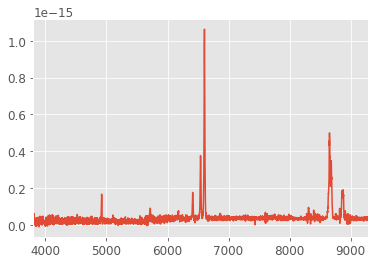

In [16]:
fig, ax = plt.subplots()
ax.set_xlim(3800, 9284)

plt.plot(wavelength, flux)
plt.show()

### Build a PySpecKit Spectrum

In [17]:
sp = pyspeckit.Spectrum(data=flux, xarr=wavelength, error=error, unit='erg/s/cm^2/AA', xarrkwargs={'unit':'AA'},header=datafile[0].header)

'erg/cm2/s/A' contains multiple slashes, which is discouraged by the FITS standard


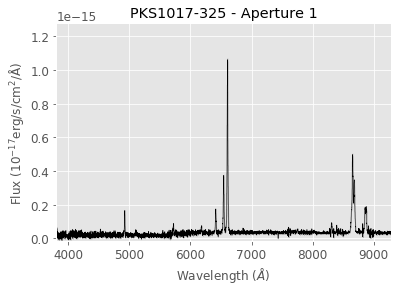

In [18]:
sp.plotter(errstyle='fill')
sp.plotter.axis.set_xlabel(r'Wavelength $(\AA)$')
sp.plotter.axis.set_ylabel(r'Flux $(10^{-17} \mathrm{erg/s/cm^2/\AA})$')
sp.plotter.refresh()

### Initial Redshift Guess

#### The redshift of the source is about 0.3186. 
I know this because the lines were trivially identifiable by the spectrum. By eye, the [O III] 5007 line peak was at 6602 \AA, corresponding to a (1+z) of (6602 / 5007) = 1.3186 (i.e., a z of 0.3186).

We'll fit the [O III] and H$\beta$ region, which is nice and clean and good for a redshift. Let's zoom in on it: 

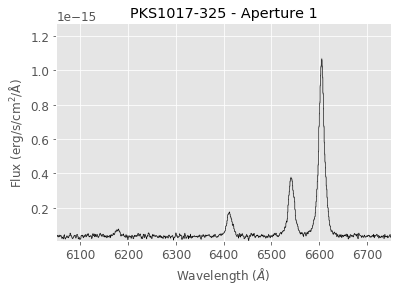

In [19]:
sp.plotter(xmin=6050, xmax=6750, errstyle='fill')
sp.plotter.axis.set_xlabel(r'Wavelength $(\AA)$')
sp.plotter.axis.set_ylabel(r'Flux $(\mathrm{erg/s/cm^2/\AA})$')
sp.plotter.refresh()

Set rest wavelengths of the lines we know we're fitting: 

In [78]:
# Clear line detections in this window, from blue to red: 

o3region_linewavs = {'HeII' : 4685.7,  
                     'Hbeta' : 4861.34, 
                     'OIII4959' :4958.9,
                     'OIII5007' : 5006.8
                    }


#o3region_linewavs = {  
#                     'Hbeta' : 4861.34, 
#                     'OIII4959' :4958.9,
#                     'OIII5007' : 5006.8
#                    }


By eye, I know the redshift is about z=0.31868

In [79]:
z_guess = 0.31868
z_guess_factor = (1 + z_guess)

I also know that the Gaussian FWHM of each of these four lines is about 15 angstroms

In [80]:
fwhm_guess = 15.

# I just quickly estimated this in IRAF SPLOT.
# I could also estimate this in python, with 
# width_guess = data.sum() / amplitude_guess / np.sqrt(2*np.pi)

Let's estimate line amplitudes, and also make a dictionary of our redshifted lines (assuming our z_guess_factor)

In [81]:
o3region_amplitudes = {}
for line in o3region_linewavs:
    sp.specfit.selectregion(xmin = o3region_linewavs[line] *z_guess_factor - 30, xmax = o3region_linewavs[line]*z_guess_factor + 30)
    amp = np.max(sp.data[sp.specfit.xmin:sp.specfit.xmax])
    d = {line : amp}
    o3region_amplitudes.update(d)
    
o3region_redshifted_lines = {}
for line in o3region_linewavs:
    redline = o3region_linewavs[line] * z_guess_factor
    d = {line : redline}
    o3region_redshifted_lines.update(d)    
    

o3region_redshifted_lines

{'Hbeta': 6410.5518312,
 'HeII': 6178.938876,
 'OIII4959': 6539.202252,
 'OIII5007': 6602.367024000001}

In [82]:
o3region_amplitudes

{'Hbeta': 1.7534279e-16,
 'HeII': 7.6285825e-17,
 'OIII4959': 3.7520897e-16,
 'OIII5007': 1.0626776e-15}

In [83]:
o3region_linewavs

{'Hbeta': 4861.34, 'HeII': 4685.7, 'OIII4959': 4958.9, 'OIII5007': 5006.8}

#### Make an inititial fit with guesses

Guesses should be constructed as: 

```python
guesses = [ AMPLITUDE_GUESS, CENTER_GUESS, WIDTH_GUESS,
            AMPLITUDE_GUESS, CENTER_GUESS, WIDTH_GUESS,]
```
and so on. One line for each gaussian you want to fit. Guesses should take the format of: 

```python
guesses = [amplitude_guess, center_guess, width_guess]
```
Multiple components are strung along in one list, e.g. 
```python
guesses = [amplitude, center, width,            # i.e. [amp, center, width] of gaussian 1
           amplitude, center, width,            # ... guassian 2
           amplitude, center, width]            # ... gaussian 3 (and so on...)
```

In [84]:
guesses = []
# Remember, dictonaries aren't ordered. Force it to be with sorted() so that we go blue --> red
for line in sorted(o3region_linewavs):
    guess = [o3region_amplitudes[line], o3region_redshifted_lines[line], fwhm_guess]
    print(line)
    print(guess)
    guesses += guess
    
guesses

Hbeta
[1.7534279e-16, 6410.5518312, 15.0]
HeII
[7.6285825e-17, 6178.938876, 15.0]
OIII4959
[3.7520897e-16, 6539.202252, 15.0]
OIII5007
[1.0626776e-15, 6602.367024000001, 15.0]


[1.7534279e-16,
 6410.5518312,
 15.0,
 7.6285825e-17,
 6178.938876,
 15.0,
 3.7520897e-16,
 6539.202252,
 15.0,
 1.0626776e-15,
 6602.367024000001,
 15.0]

In [75]:
guesses

[1.7534279e-16,
 6410.5518312,
 15.0,
 3.7520897e-16,
 6539.202252,
 15.0,
 1.0626776e-15,
 6602.367024000001,
 15.0]

#### We could make a baseline, if we wanted to, i.e. with

```python
linemask = []
for line in o3region_linewavs:
    xmin = o3region_linewavs[line] - 30.0
    xmax = o3region_linewavs[line] + 30.0
    mask = [xmin, xmax]
    linemask += mask
    
linemask

# Then fit baseline with
sp.baseline(xmin=6050, xmax=6750, exclude=linemask, subtract=False, reset_selection=False, highlight_fitregion=True, order=1)
```

### Do the fit

INFO: Renormalizing data by factor 3.248316e-17 to improve fitting procedure [pyspeckit.spectrum.fitters]
INFO: Renormalizing data by factor 3.248316e-17 to improve fitting procedure [pyspeckit.spectrum.fitters]


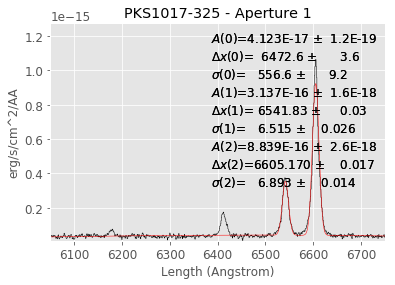

In [76]:
sp.plotter()
sp.specfit(guesses=list(guesses), fittype='gaussian')
sp.specfit(guesses=list(guesses), fittype='gaussian')

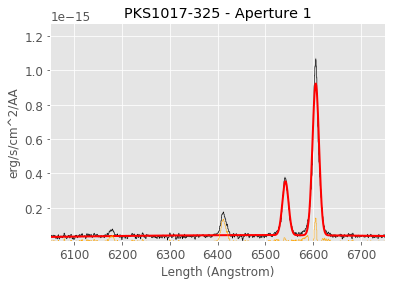

In [77]:
sp.plotter(xmin=6050, xmax=6750, errstyle='fill')
sp.specfit.plot_fit(annotate=False, lw=2.0)
sp.specfit.plot_components(add_baseline=True,component_yoffset=+1.0)
sp.specfit.plotresiduals(axis=sp.plotter.axis,clear=False,yoffset=0.0,label=False, color='orange')

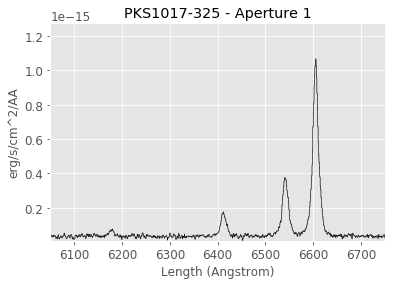

In [30]:
sp.specfit.highlight_fitregion()
sp.plotter(xmin=6050, xmax=6750, errstyle='fill')

In [31]:
sp.specfit.print_fit()

     AMPLITUDE0:  8.32704e-16 +/-  2.30024e-18
         SHIFT0:      6605.24 +/-    0.0162456
         WIDTH0:      8.10753 +/-    0.0135583
     AMPLITUDE1:  5.69569e-33 +/-            0
         SHIFT1:      6410.55 +/-            0
         WIDTH1:           15 +/-            0
     AMPLITUDE2:   1.2188e-32 +/-            0
         SHIFT2:       6539.2 +/-            0
         WIDTH2:           15 +/-            0
     AMPLITUDE3:    2.478e-33 +/-            0
         SHIFT3:      6178.94 +/-            0
         WIDTH3:           15 +/-            0
